# Data import and selection

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Open .csv as a Dataframe
filename = "31688.csv"
weather_data = pd.read_csv(f"..\\data\\raw\\weather_data\\climate_data\\daily\\{filename}")

# Select only relevant columns
weather_data = weather_data.iloc[:, [2,4,5,6,7,9,11,13,15,17,19,23,29]]

# Select only months 5-9 (rough overlapping timeframe with the BeachWaterSafety data)
weather_data = weather_data.loc[weather_data['Month'].isin([5,6,7,8,9])]

# Convert datetime str column to datetime object
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'])
weather_data.drop(columns=["Year", "Month", "Day"], axis=1, inplace=True)

weather_data.info()
weather_data.tail



<class 'pandas.core.frame.DataFrame'>
Index: 33048 entries, 120 to 78807
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Station Name            33048 non-null  object        
 1   Date/Time               33048 non-null  datetime64[ns]
 2   Max Temp (°C)           32736 non-null  float64       
 3   Min Temp (°C)           32772 non-null  float64       
 4   Mean Temp (°C)          32688 non-null  float64       
 5   Heat Deg Days (°C)      32688 non-null  float64       
 6   Cool Deg Days (°C)      32688 non-null  float64       
 7   Total Rain (mm)         0 non-null      float64       
 8   Total Precip (mm)       32388 non-null  float64       
 9   Spd of Max Gust (km/h)  0 non-null      float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 2.8+ MB


C:\Users\olimoon\AppData\Local\Temp\ipykernel_20656\798726250.py:7: DtypeWarning: Columns (20,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(f"..\\data\\raw\\weather_data\\climate_data\\daily\\{filename}")


<bound method NDFrame.tail of        Station Name  Date/Time  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
120    TORONTO CITY 2007-05-01           10.7            7.9             9.3   
121    TORONTO CITY 2007-05-02           15.6            6.2            10.9   
122    TORONTO CITY 2007-05-03           14.6            8.8            11.7   
123    TORONTO CITY 2007-05-04           17.5            8.8            13.2   
124    TORONTO CITY 2007-05-05           18.9            9.2            14.1   
...             ...        ...            ...            ...             ...   
78803  TORONTO CITY 2024-09-26           24.9           16.7            20.8   
78804  TORONTO CITY 2024-09-27           22.7           14.6            18.7   
78805  TORONTO CITY 2024-09-28           22.5           18.6            20.5   
78806  TORONTO CITY 2024-09-29           22.8           17.3            20.1   
78807  TORONTO CITY 2024-09-30           22.7           16.7            19.7   

       He

Write to file

In [25]:
import re

# Get and format beach name
stn_name = weather_data.iloc[0]['Station Name'] # Assuming only one beach name at a time 
stn_name = stn_name.lower().replace(" ", "_")
stn_name = re.sub(f'[^a-z0-9_]', "", stn_name)

print(stn_name)
# Write to file 
weather_data.to_parquet(f"..\\data\\cleaned\\cleaned_{stn_name}.parquet")

toronto_city


# Data Exploration

Rainfall exploration

In [3]:
has_precip = weather_data['Total Precip (mm)'] > 0 # 11892 entries in Toronto City
weather_data.loc[has_precip]

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
129,-79.4,43.67,TORONTO CITY,6158355,2007-05-10,2007,5,10,NaN,22.9,...,NaN,M,2.9,NaN,NaN,NaN,NaN,M,NaN,M
134,-79.4,43.67,TORONTO CITY,6158355,2007-05-15,2007,5,15,NaN,29.7,...,NaN,M,28.0,NaN,NaN,NaN,NaN,M,NaN,M
135,-79.4,43.67,TORONTO CITY,6158355,2007-05-16,2007,5,16,NaN,15.8,...,NaN,M,13.0,NaN,NaN,NaN,NaN,M,NaN,M
146,-79.4,43.67,TORONTO CITY,6158355,2007-05-27,2007,5,27,NaN,18.9,...,NaN,M,7.5,NaN,NaN,NaN,NaN,M,NaN,M
150,-79.4,43.67,TORONTO CITY,6158355,2007-05-31,2007,5,31,NaN,28.0,...,NaN,M,1.7,NaN,NaN,NaN,NaN,M,NaN,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78799,-79.4,43.67,TORONTO CITY,6158355,2024-09-22,2024,9,22,NaN,24.4,...,NaN,NaN,0.2,NaN,NaN,NaN,NaN,M,NaN,M
78800,-79.4,43.67,TORONTO CITY,6158355,2024-09-23,2024,9,23,NaN,21.9,...,NaN,NaN,19.9,NaN,NaN,NaN,NaN,M,NaN,M
78801,-79.4,43.67,TORONTO CITY,6158355,2024-09-24,2024,9,24,NaN,19.5,...,NaN,NaN,16.0,NaN,NaN,NaN,NaN,M,NaN,M
78802,-79.4,43.67,TORONTO CITY,6158355,2024-09-25,2024,9,25,NaN,22.9,...,NaN,NaN,3.4,NaN,NaN,NaN,NaN,M,NaN,M


Plot date vs. precipitation

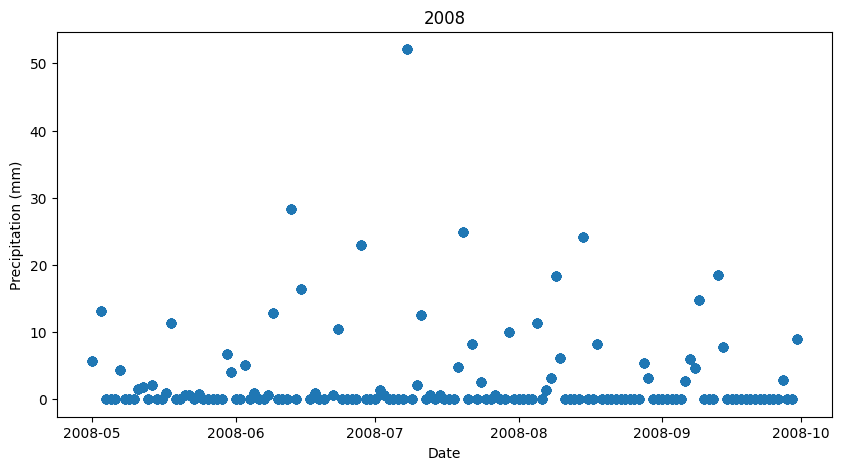

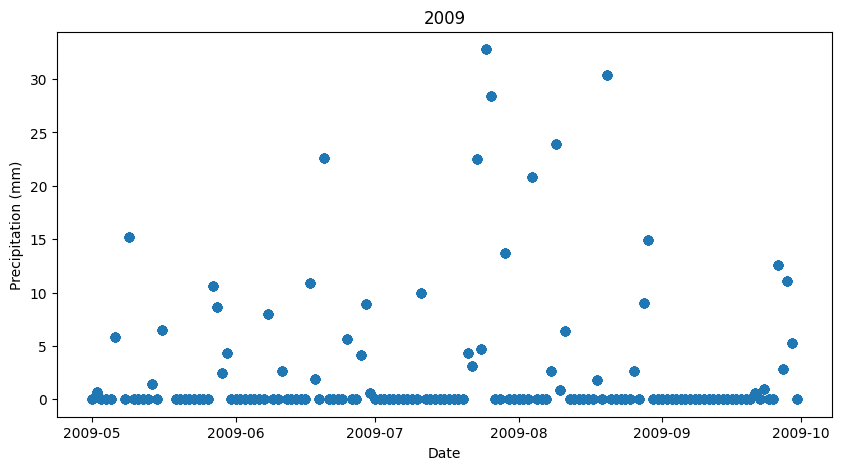

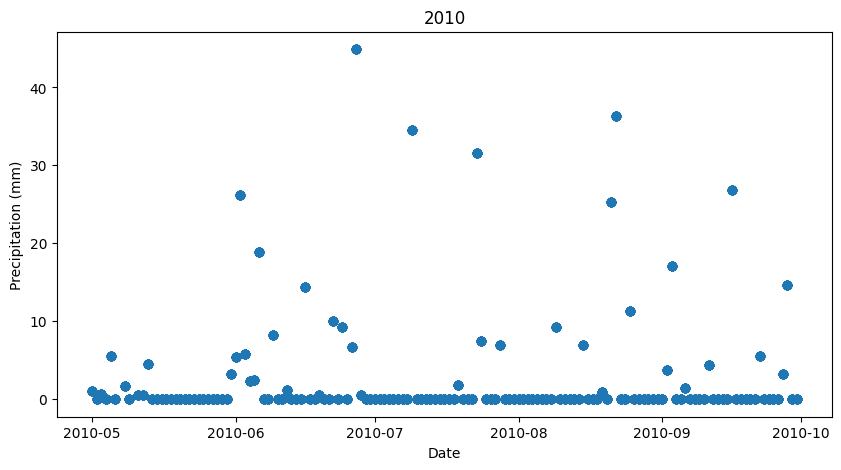

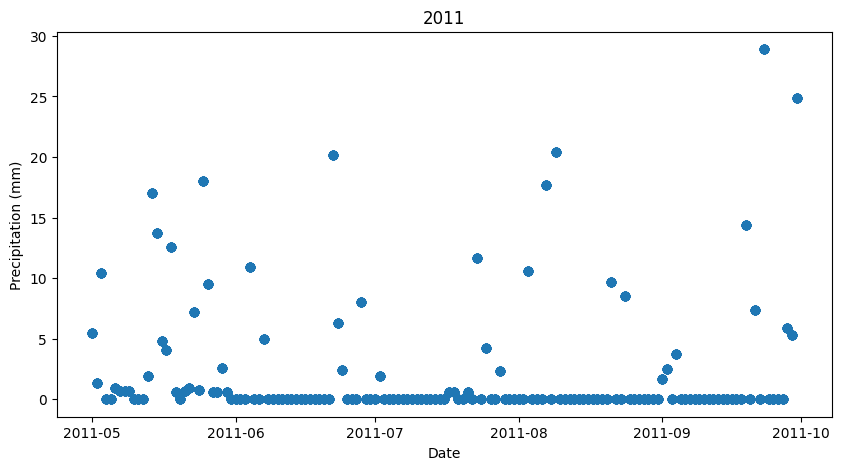

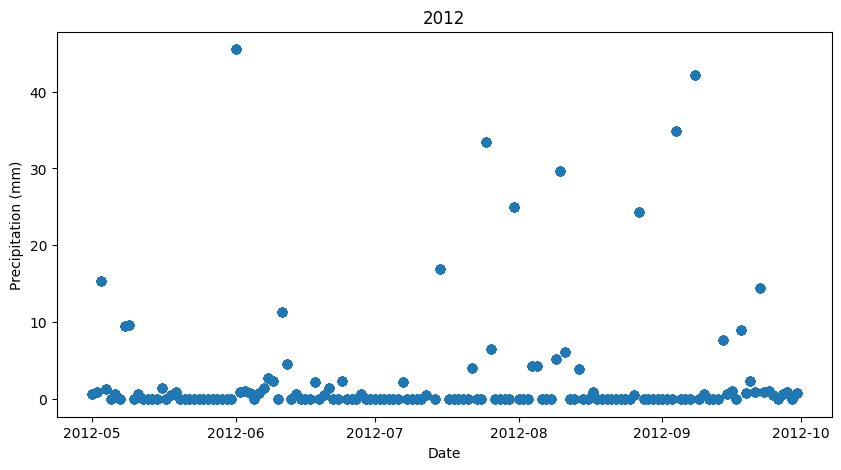

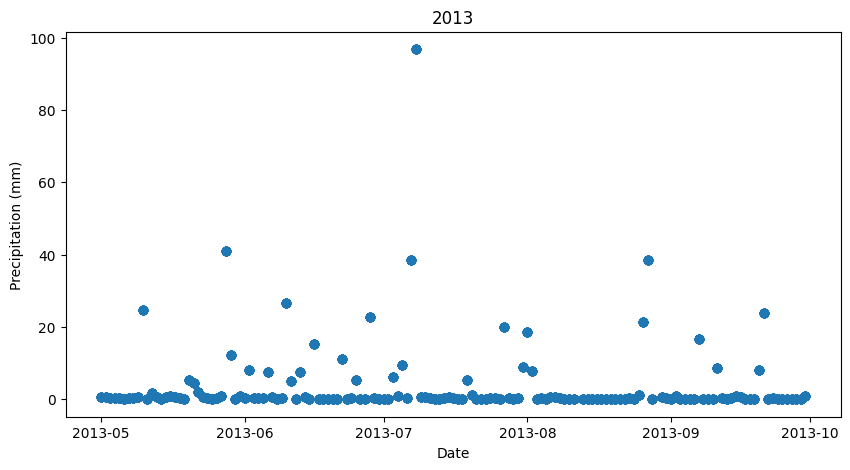

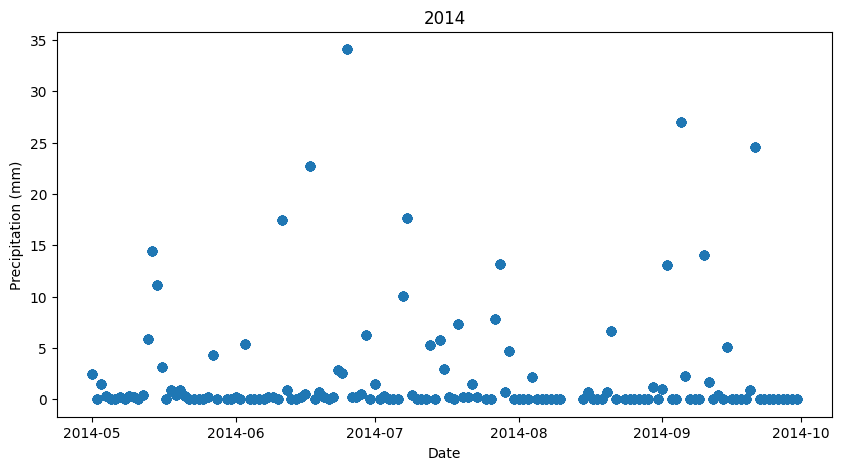

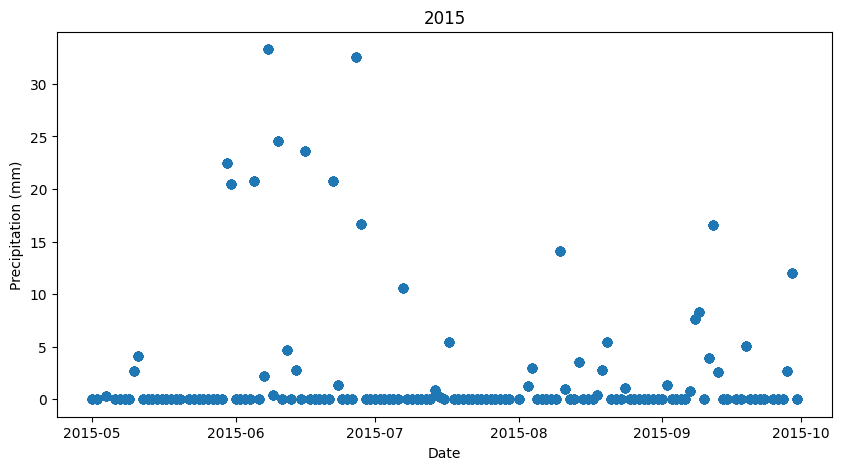

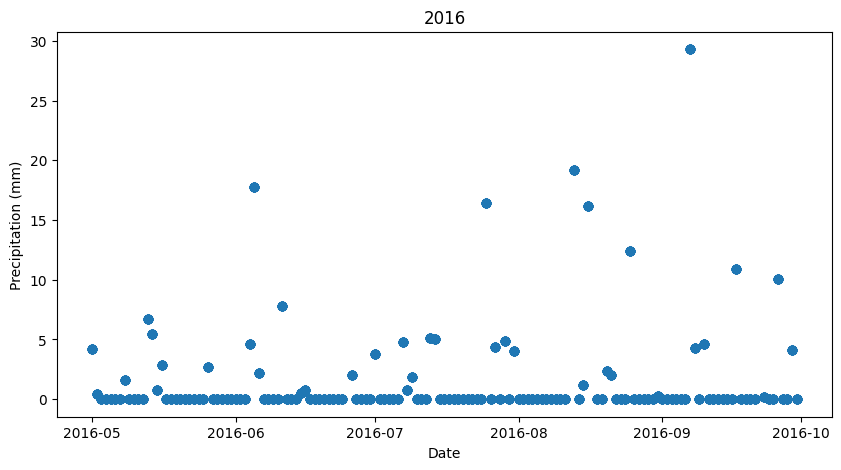

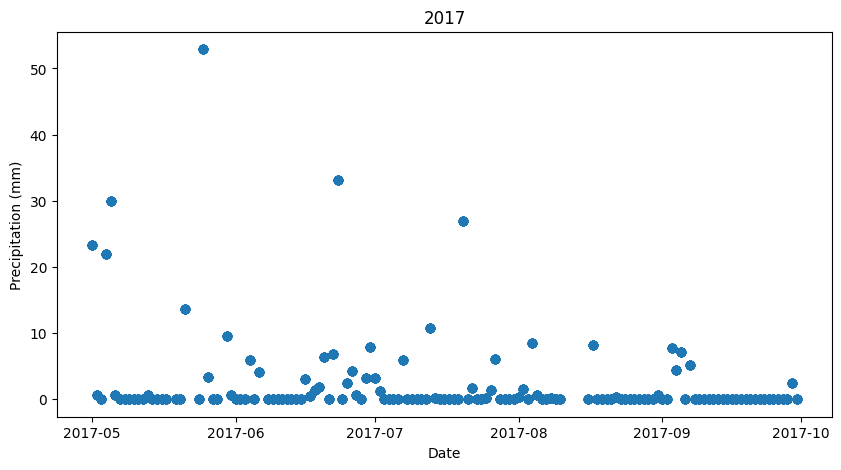

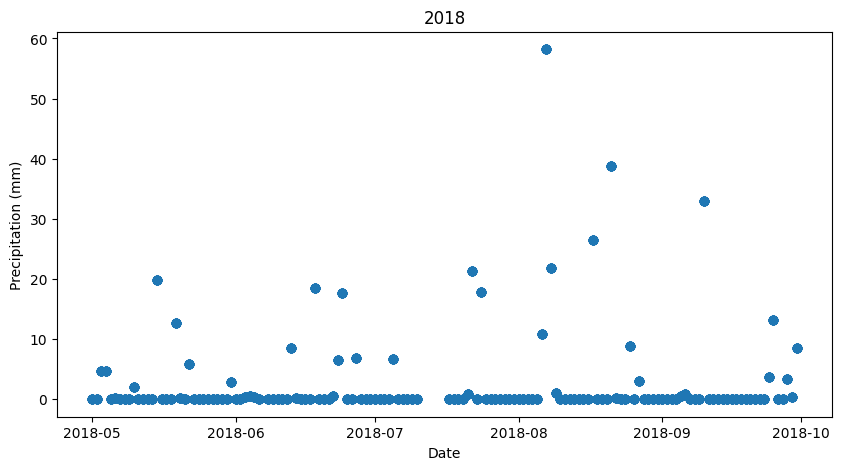

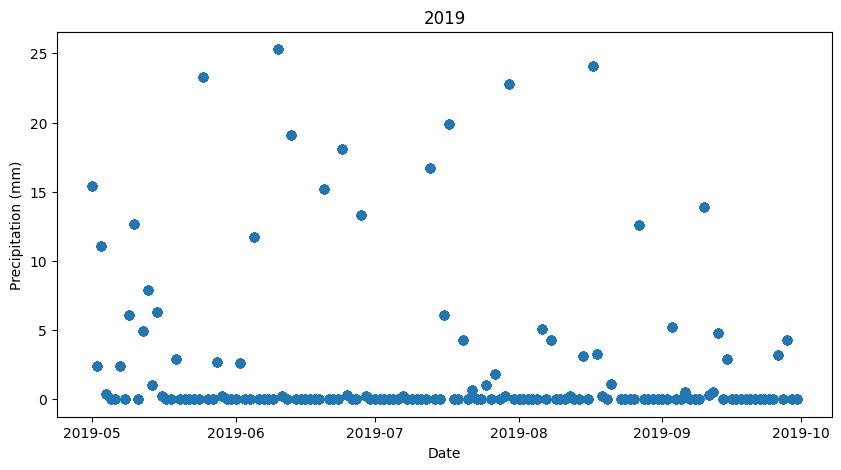

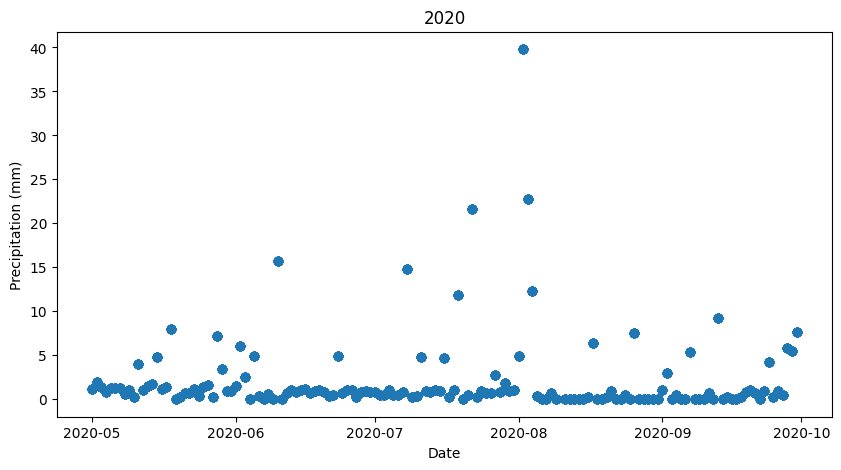

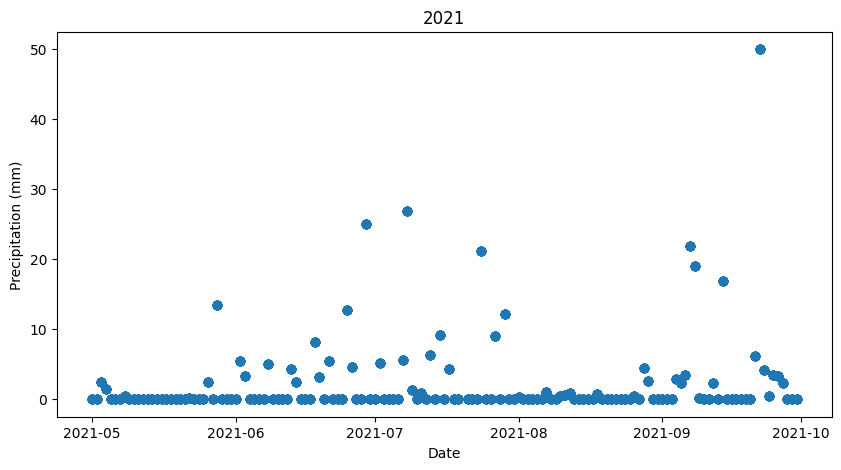

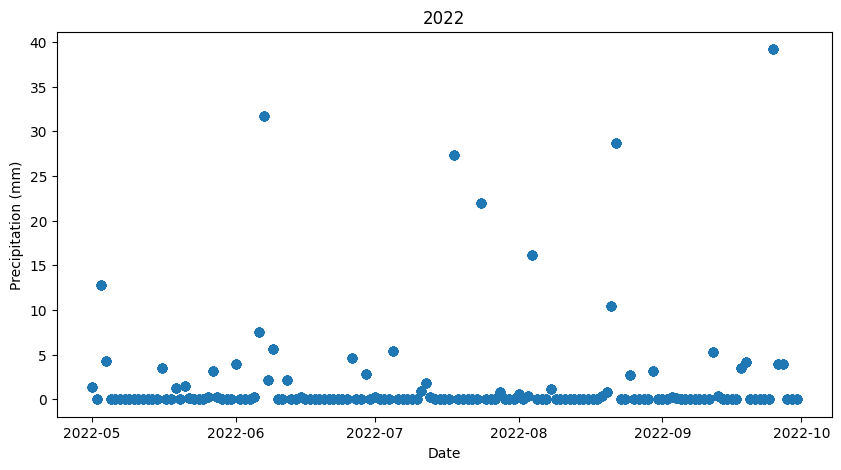

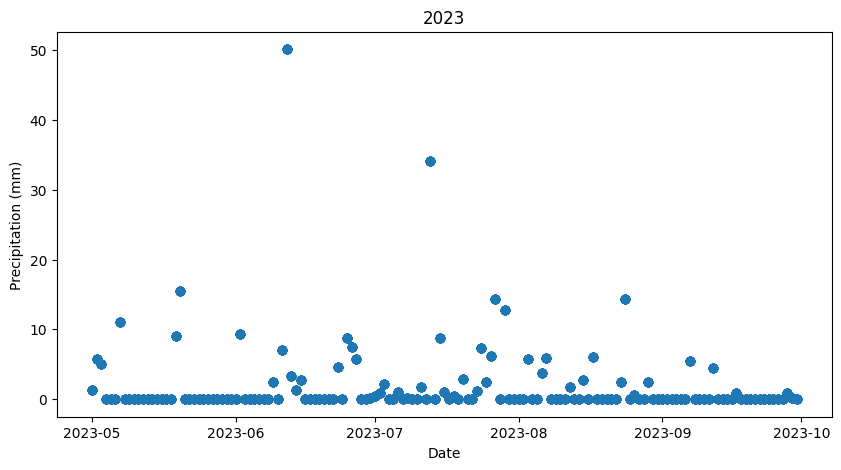

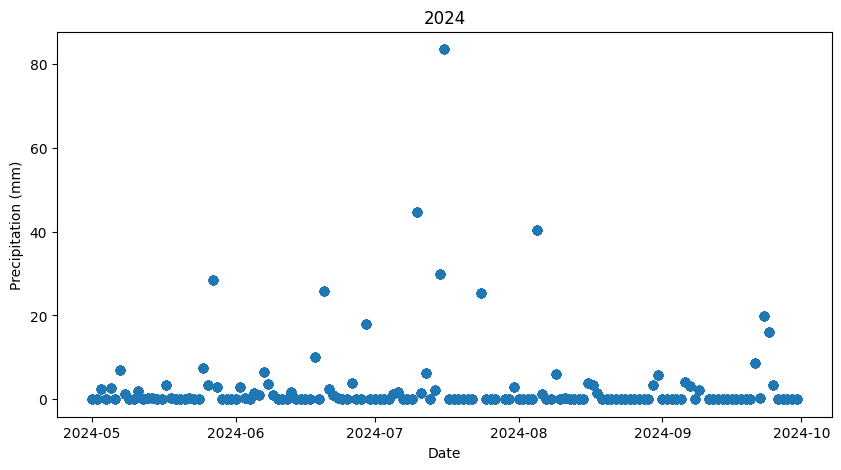

In [4]:
for i in range(2008, 2025):
    plt.figure(figsize=(10,5))
    mask = weather_data['Date/Time'].dt.year == i
    plt.scatter(weather_data['Date/Time'].loc[mask], weather_data['Total Precip (mm)'].loc[mask])
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.title(f'{i}')
    plt.show()

In [5]:
# Inspect ecoli anomaly 